In [90]:
# save to json file 
import json
with open('aggregated data.json', 'r') as file:
    jsondata = json.load(file)

import re
CLEANR = re.compile('<.*?>') 
def cleanhtml(raw_html):
  cleantext = re.sub("<br>", '. ', raw_html)
  cleantext = re.sub(CLEANR, ' ', cleantext)
  cleantext = re.sub('nbsp', ' ', cleantext)
  return cleantext

data = []
for charity in jsondata:
    for campaign in charity['list_campaigns']:
        donations_count = len(campaign['list_donations'])
        donation_amount = sum([donation['amount'] for donation in campaign['list_donations']])/100
        comments_count = len(campaign['list_comments'])
        charity_item = {
        "charity_name" : charity['name'],
        "campaign_name" : campaign['title'],
        "detailedStory" : cleanhtml(campaign['detailedStory']),
        "donations_count" : donations_count,
        "donation_amount" : donation_amount,
        "comments_count" : comments_count
        }
        data.append(charity_item)

In [2]:
import pandas as pd
import numpy as np
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# Load the English NLP model
nlp = spacy.load("en_core_web_sm")

# Sample DataFrame

raw_data = pd.DataFrame(data)
df = raw_data[['detailedStory', 'donations_count', 'donation_amount']].copy()

def clean_text(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return ' '.join(tokens)

df['cleaned_story'] = df['detailedStory'].apply(clean_text)

# 2. POS Tagging: extract nouns, adjectives, and verbs
def extract_pos(text):
    doc = nlp(text)
    nouns = {token.lemma_ for token in doc if token.pos_ == "NOUN"}
    adjectives = {token.lemma_ for token in doc if token.pos_ == "ADJ"}
    verbs = {token.lemma_ for token in doc if token.pos_ == "VERB"}
    return nouns, adjectives, verbs

df['nouns'], df['adjectives'], df['verbs'] = zip(*df['cleaned_story'].apply(extract_pos))

# 3. Sentiment Analysis for adjectives, nouns, and verbs
def get_sentiment_score(words):
    return np.mean([TextBlob(word).sentiment.polarity for word in words]) if words else 0

df['noun_sentiment'] = df['nouns'].apply(get_sentiment_score)
df['adj_sentiment'] = df['adjectives'].apply(get_sentiment_score)
df['verb_sentiment'] = df['verbs'].apply(get_sentiment_score)

# Count positive and negative nouns, verbs, and adjectives
def count_sentiment_words(text, pos):
    doc = nlp(text)
    pos_words = [token.lemma_ for token in doc if token.pos_ == pos]
    pos_count = sum(1 for word in pos_words if TextBlob(word).sentiment.polarity > 0)
    neg_count = sum(1 for word in pos_words if TextBlob(word).sentiment.polarity < 0)
    return pos_count, neg_count

df['noun_pos_count'], df['noun_neg_count'] = zip(*df['cleaned_story'].apply(lambda x: count_sentiment_words(x, "NOUN")))
df['adj_pos_count'], df['adj_neg_count'] = zip(*df['cleaned_story'].apply(lambda x: count_sentiment_words(x, "ADJ")))
df['verb_pos_count'], df['verb_neg_count'] = zip(*df['cleaned_story'].apply(lambda x: count_sentiment_words(x, "VERB")))

# Prepare sentiment features for imputation
sentiment_features = df[['noun_sentiment', 'adj_sentiment', 'verb_sentiment']]
imputer = SimpleImputer(strategy='mean')
sentiment_features_imputed = imputer.fit_transform(sentiment_features)

# Clustering using K-Means based on sentiment scores
num_clusters = 6 # Adjust as necessary
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(sentiment_features_imputed)

# Correlation analysis
correlation = df[['cluster', 'donations_count', 'donation_amount', 
                  'noun_pos_count', 'noun_neg_count', 
                  'adj_pos_count', 'adj_neg_count', 
                  'verb_pos_count', 'verb_neg_count']].corr()

# Display the DataFrame
print(df[['detailedStory', 'cleaned_story', 
           'nouns', 'adjectives', 'verbs', 
           'noun_pos_count', 'noun_neg_count', 
           'adj_pos_count', 'adj_neg_count', 
           'verb_pos_count', 'verb_neg_count', 
           'noun_sentiment', 'adj_sentiment', 'verb_sentiment', 
           'cluster']])

# Optional: Visualization of the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Matrix')
plt.show()

NameError: name 'data' is not defined

In [ ]:
# Optional: Visualization of the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Matrix')
plt.show()

In [91]:
df

,detailedStory,donations_count,donation_amount,cleaned_story,nouns,adjectives,verbs,noun_sentiment,adj_sentiment,verb_sentiment,noun_pos_count,noun_neg_count,adj_pos_count,adj_neg_count,verb_pos_count,verb_neg_count,cluster
0,“The monthly FoodAid worth $250 from the Si...,47,1591.0,monthly FoodAid worth $ 250 Singapore Red ...,"{touch, diet, organ, cancer, affirm, remind, i...","{worth, bad, bedridden, important, modest, siz...","{grow, matter, divide, face, enjoy, thank, dec...",0.003784,0.114970,0.001716,2,1,19,5,2,1,3
1,"Superman, Batman, Spider-Man – every superhe...",16,15775.0,Superman Batman Spider Man superhero get im...,"{detail, inspect, medium, victim, spirit, cont...","{uplift, structural, critical, available, tact...","{operate, execute, know, maintain, indicate, o...",-0.002865,0.047429,0.000000,4,5,8,1,0,0,0
2,"DHL, Ten Square, Singapore Red Cross and Mini...",73,4808.0,DHL Square Singapore Red Cross Mini Fanatics...,"{night, dough, marry, challenge, school, rappo...","{happy, young, lean, low, precious, good, old,...","{maintain, serve, write, accompany, teach, rea...",0.013115,0.197854,0.000000,1,0,10,2,0,0,5
3,Singapore Red Cross is organising Grateful H...,2,115.0,Singapore Red Cross organise Grateful Heart...,"{life, theme, impact, child, fundraiser, suppo...","{uplift, good, future, annual, elderly, social...","{touch, need, translate, bring, hope}",0.000000,0.036970,0.000000,0,0,3,2,0,0,0
4,"Join us to eat, play, shop for a good cause! ...",124,10536.0,join eat play shop good cause Singapore...,"{interact, life, fund, feature, train, return,...","{uplift, warm, standard, collaborative, senior...","{enjoy, go, walk, enable, donation, represent,...",-0.005460,0.060271,0.021053,0,1,5,3,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524,DSA's Mystique Charity Gala Dinner is back !...,0,0.0,DSA Mystique Charity Gala Dinner hel...,"{platform, fund, face, challenge, recognise, s...","{monetary, essential, endemic, new, positive, ...","{provide, achieve, raise, continue, serve, req...",0.000000,0.060606,0.000000,0,0,2,0,0,0,0
525,Be the one who helps. Your gift can uplift th...,46,1760.0,help gift uplift life child syndrome bring s...,"{life, dollar, communication, mentor, developm...","{uplift, worried, confused, early, long, futur...","{hear, meet, improve, find, lose, thank, commu...",0.000000,0.064351,0.000000,0,0,5,2,0,0,0
526,Give a gift of hope. . 2021 has been a ...,9,460.0,gift hope 2021 year fill transition ...,"{caregiver, life, communication, challenge, tr...","{uplift, worried, confused, early, empower, fu...","{provide, hear, meet, improve, include, contin...",0.000000,0.069774,0.000000,0,0,7,2,0,0,0
527,"Celebrated on 21 March annually, World Down S...",26,1479.0,celebrate 21 March annually World Syndrome D...,"{model, life, cent, condition, impact, approac...","{fundamental, global, human, genetic, unique, ...","{ask, advocate, improve, thank, need, commit, ...",-0.014286,0.082589,0.000000,2,2,6,0,0,0,0


In [103]:
# Export the DataFrame as a CSV file
df.to_csv('charity_data_sentiment.csv', index=False)

In [102]:
# Count the occurrences of each cluster
cluster_counts = df['cluster'].value_counts()
print(cluster_counts)

# Calculate the average number of positive and negative words for each cluster
avg_pos_neg_words = df.groupby('cluster')[['noun_pos_count', 'noun_neg_count', 'adj_pos_count', 'adj_neg_count', 'verb_pos_count', 'verb_neg_count', 'donation_amount','donations_count']].mean()
avg_pos_neg_words

cluster
0    170
3    142
2    138
5     66
1     11
4      2
Name: count, dtype: int64


,noun_pos_count,noun_neg_count,adj_pos_count,adj_neg_count,verb_pos_count,verb_neg_count,donation_amount,donations_count
cluster,,,,,,,,
0,0.817647,0.405882,5.829412,2.382353,0.341176,0.170588,5874.538235,46.741176
1,0.454545,0.000000,3.090909,0.000000,0.454545,0.090909,1723.363636,15.272727
2,0.528986,0.202899,2.210145,2.347826,0.210145,0.079710,4816.677536,55.137681
3,0.760563,0.316901,7.000000,1.521127,0.302817,0.063380,2115.338732,17.591549
4,0.500000,0.000000,0.000000,1.500000,0.000000,0.000000,0.000000,0.000000
5,0.560606,0.439394,5.878788,0.378788,0.272727,0.045455,1832.061364,25.030303


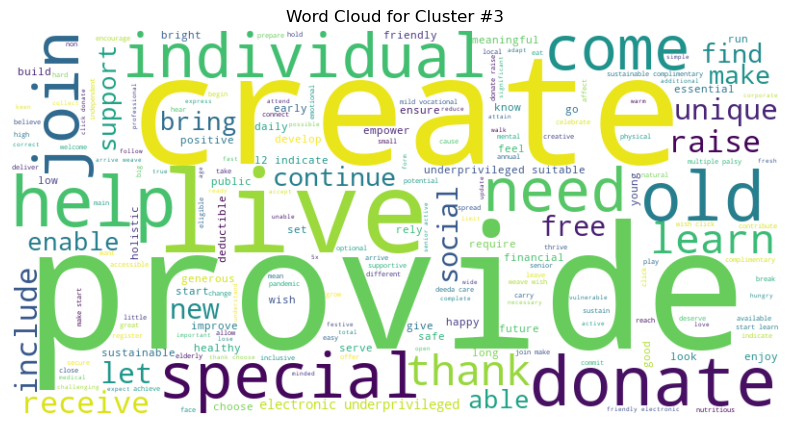

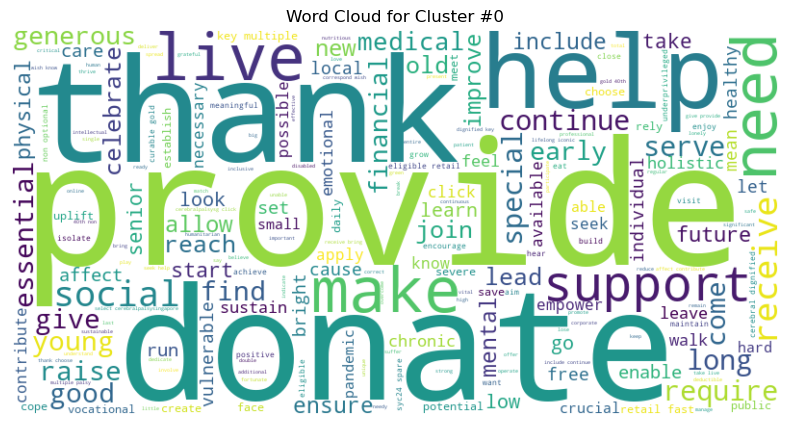

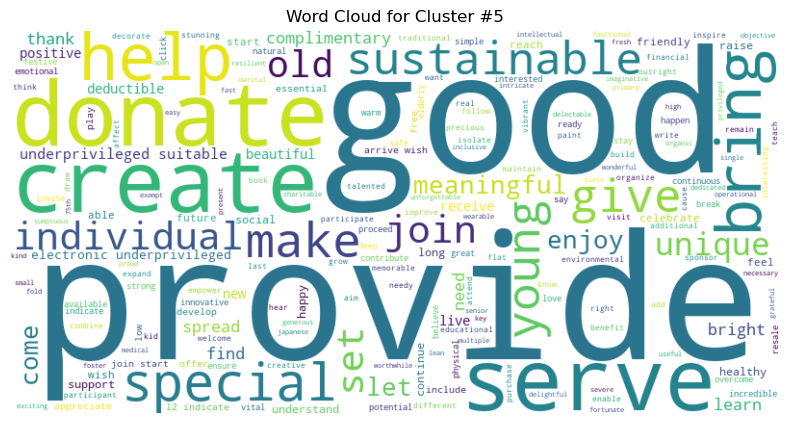

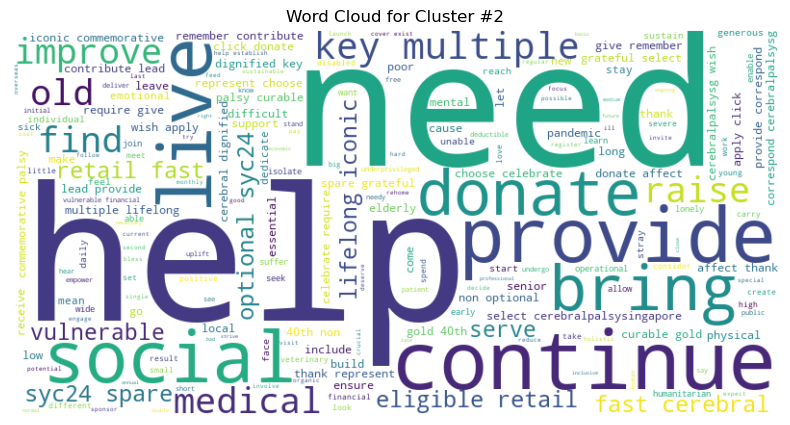

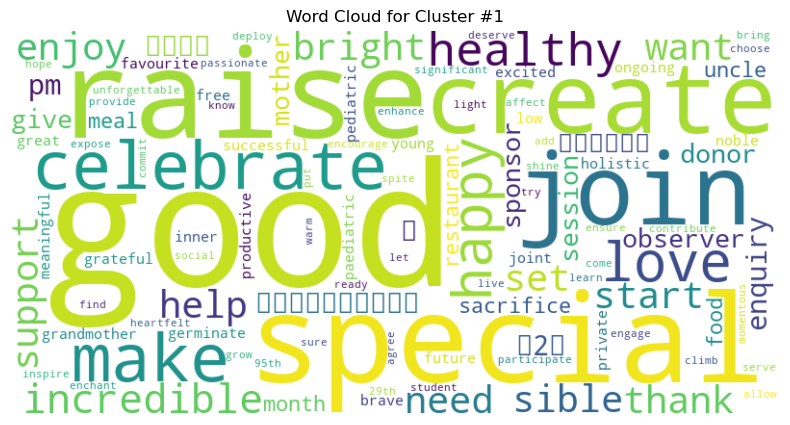

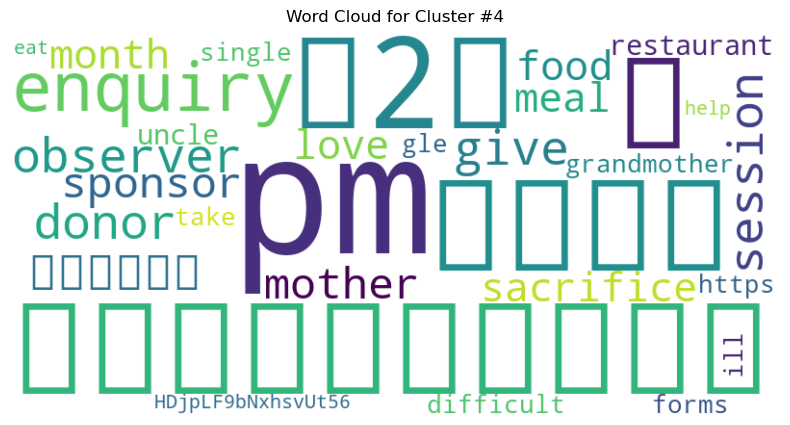

In [97]:


# Generate word clouds for each cluster
for cluster_num in df['cluster'].unique():
    cluster_data = df[df['cluster'] == cluster_num]
    # nouns = ' '.join(cluster_data['nouns'].apply(lambda x: ' '.join(x)))
    adjectives = ' '.join(cluster_data['adjectives'].apply(lambda x: ' '.join(x)))
    verbs = ' '.join(cluster_data['verbs'].apply(lambda x: ' '.join(x)))
    text = f"{nouns} {adjectives} {verbs}"
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for Cluster #{cluster_num}")
    plt.show()

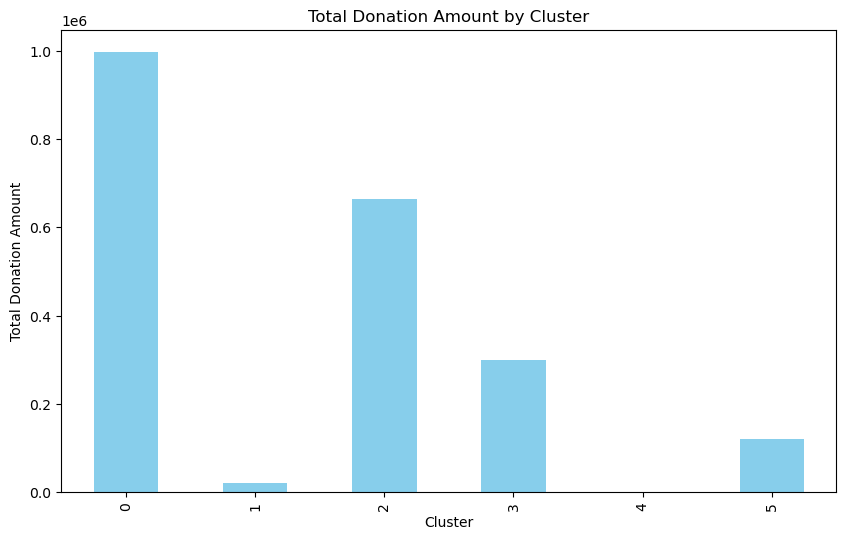

In [89]:
# Group by 'cluster' and sum the 'donation_amount'
donation_by_cluster = df.groupby('cluster')['donation_amount'].sum()

# Plot the donation amount by cluster
donation_by_cluster.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Total Donation Amount')
plt.title('Total Donation Amount by Cluster')
plt.show()